# **Step 1: Import Necessary Libraries**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image # For loading single images for prediction

import zipfile
import os
import pandas as pd # Added for loading CSV files
import numpy as np
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")

# Check for GPU availability (Colab T4 GPU should be detected)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices}")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("No GPU detected, model will run on CPU.")

TensorFlow version: 2.18.0
Pandas version: 2.2.2
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **Step 2: Unzip the Dataset**

In [3]:
zip_file_path = '/content/Marine.zip'
extract_to_dir = '/content/Marine_Dataset' # This will be the base directory

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_to_dir):
    os.makedirs(extract_to_dir)

# Unzip the file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)
    print(f"Successfully extracted '{zip_file_path}' to '{extract_to_dir}'")

    print("\nVerifying contents of the extracted directory:")
    for item in os.listdir(extract_to_dir):
        print(f"- {item}")
        if os.path.isdir(os.path.join(extract_to_dir, item)) and item in ['train', 'valid', 'test']:
            print(f"  Sample contents of {item}: {os.listdir(os.path.join(extract_to_dir, item))[:5]}")

except FileNotFoundError:
    print(f"ERROR: Zip file not found at '{zip_file_path}'. Please ensure it's uploaded correctly.")
    raise SystemExit("Zip file not found. Halting execution.")
except Exception as e:
    print(f"ERROR: An error occurred during unzipping: {e}")
    raise SystemExit(f"Unzipping error. Halting execution: {e}")

Successfully extracted '/content/Marine.zip' to '/content/Marine_Dataset'

Verifying contents of the extracted directory:
- test
  Sample contents of test: ['image_20241007_084911_730047_jpg.rf.2d7ebddfb361f828eb72e9e2e0733913.jpg', 'image_20241006_151507_372163_jpg.rf.2e1883e077a4e3623c8c32522f5b9a2a.jpg', 'image_20241006_090934_218451_jpg.rf.8e55d4d6ecb7c581219d2eb18680cf6a.jpg', 'image_20241006_151408_100791_jpg.rf.2694da85cdb15d30ca377fe873b842f4.jpg', 'image_20241118_112541_726135_jpg.rf.e9c1ee67bdbabe3cbbe1de44a8d6b561.jpg']
- train
  Sample contents of train: ['image_20241006_152026_351649_jpg.rf.f36de21405f252faeb6697b0125ff559.jpg', 'image_20241004_143524_670577_jpg.rf.7a80148c2dbcc71cc66716e93ecb9616.jpg', 'image_20241007_093250_812478_jpg.rf.a385d2ff5e9bce897626a90a4dfaf9fd.jpg', 'image_20241006_082749_139309_jpg.rf.16f621bec2bd8e74579b4e7ca15fafb8.jpg', 'image_20241006_083032_277472_jpg.rf.fad7c000348d35d118def6bf20b6b473.jpg']
- valid
  Sample contents of valid: ['image_20

# **Step 3: Define Paths and Dataset Parameters**

In [4]:
base_dir = extract_to_dir

train_img_dir = os.path.join(base_dir, 'train')
validation_img_dir = os.path.join(base_dir, 'valid')
test_img_dir = os.path.join(base_dir, 'test')

train_csv_path = os.path.join(train_img_dir, '_classes.csv')
validation_csv_path = os.path.join(validation_img_dir, '_classes.csv')
test_csv_path = os.path.join(test_img_dir, '_classes.csv')

for path_to_check in [train_img_dir, validation_img_dir, test_img_dir, train_csv_path, validation_csv_path, test_csv_path]:
    if not os.path.exists(path_to_check):
        print(f"ERROR: Required file or directory not found at '{path_to_check}'")
        raise SystemExit(f"Missing critical file/directory: {path_to_check}. Halting execution.")
    else:
        print(f"Found: {path_to_check}")

IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
# Define our target class names. We will map 0/1 from CSV to these.
CLASS_NAMES = ['no_plastic', 'plastic'] # Assuming 0 maps to 'no_plastic', 1 maps to 'plastic'
FILENAME_COL = 'filename'
LABEL_COL = 'garbage' # This column in _classes.csv contains 0s or 1s

Found: /content/Marine_Dataset/train
Found: /content/Marine_Dataset/valid
Found: /content/Marine_Dataset/test
Found: /content/Marine_Dataset/train/_classes.csv
Found: /content/Marine_Dataset/valid/_classes.csv
Found: /content/Marine_Dataset/test/_classes.csv


# **Step 4: Prepare Data using ImageDataGenerator (with Augmentation)**

In [6]:
train_generator = None
validation_generator = None
test_generator = None
steps_per_epoch = 0
validation_steps = 0
test_steps = 0

try:
    df_train_raw = pd.read_csv(train_csv_path)
    df_validation_raw = pd.read_csv(validation_csv_path)
    df_test_raw = pd.read_csv(test_csv_path)

    print(f"\nTraining CSV ({train_csv_path}) loaded. Shape: {df_train_raw.shape}. Head:")
    print(df_train_raw.head())
    print(f"Columns: {df_train_raw.columns.tolist()}")
    if LABEL_COL in df_train_raw.columns:
        print(f"Unique values in '{LABEL_COL}' column (training): {df_train_raw[LABEL_COL].unique()}")
    else:
        raise KeyError(f"Label column '{LABEL_COL}' not found in {train_csv_path}")

    df_train = df_train_raw.copy()
    df_validation = df_validation_raw.copy()
    df_test = df_test_raw.copy()

    label_map = {0: CLASS_NAMES[0], 1: CLASS_NAMES[1]}
    df_train[LABEL_COL] = df_train[LABEL_COL].map(label_map)
    df_validation[LABEL_COL] = df_validation[LABEL_COL].map(label_map)
    df_test[LABEL_COL] = df_test[LABEL_COL].map(label_map)

    if df_train[LABEL_COL].isnull().any() or df_validation[LABEL_COL].isnull().any() or df_test[LABEL_COL].isnull().any():
        print("WARNING: Found NaN values in label column after mapping. Original 'garbage' column might contain values other than 0 or 1.")
        # Consider dropping rows with NaN labels for robustness:
        # df_train.dropna(subset=[LABEL_COL], inplace=True)
        # df_validation.dropna(subset=[LABEL_COL], inplace=True)
        # df_test.dropna(subset=[LABEL_COL], inplace=True)
        # For now, we'll proceed, but filter them out before creating generators if necessary.
        df_train = df_train.dropna(subset=[LABEL_COL])
        df_validation = df_validation.dropna(subset=[LABEL_COL])
        df_test = df_test.dropna(subset=[LABEL_COL])
        print("Rows with NaN labels have been dropped.")


    print(f"\nSample labels after mapping to strings (training data): {df_train[LABEL_COL].unique()[:5] if not df_train.empty else 'N/A'}")

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    validation_test_datagen = ImageDataGenerator(rescale=1./255)

    if not df_train.empty:
        train_generator = train_datagen.flow_from_dataframe(
            dataframe=df_train,
            directory=train_img_dir,
            x_col=FILENAME_COL,
            y_col=LABEL_COL,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            classes=CLASS_NAMES,
            shuffle=True
        )
        # --- CORRECTED PRINT STATEMENT BELOW ---
        print(f"\nFound {train_generator.n} training images belonging to {len(train_generator.class_indices)} classes.")
        print(f"Training class indices: {train_generator.class_indices}")
        if train_generator.n > 0:
            steps_per_epoch = train_generator.n // BATCH_SIZE
            if steps_per_epoch == 0: steps_per_epoch = 1
    else:
        print("ERROR: Training DataFrame is empty (possibly after dropping NaNs). Cannot create train_generator.")

    if not df_validation.empty:
        validation_generator = validation_test_datagen.flow_from_dataframe(
            dataframe=df_validation,
            directory=validation_img_dir,
            x_col=FILENAME_COL,
            y_col=LABEL_COL,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            classes=CLASS_NAMES,
            shuffle=False
        )
        # --- CORRECTED PRINT STATEMENT BELOW ---
        print(f"\nFound {validation_generator.n} validation images belonging to {len(validation_generator.class_indices)} classes.")
        if validation_generator.n > 0:
            validation_steps = validation_generator.n // BATCH_SIZE
            if validation_steps == 0: validation_steps = 1
    else:
        print("WARNING: Validation DataFrame is empty (possibly after dropping NaNs).")

    if not df_test.empty:
        test_generator = validation_test_datagen.flow_from_dataframe(
            dataframe=df_test,
            directory=test_img_dir,
            x_col=FILENAME_COL,
            y_col=LABEL_COL,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=BATCH_SIZE,
            class_mode='binary',
            classes=CLASS_NAMES,
            shuffle=False
        )
        # --- CORRECTED PRINT STATEMENT BELOW ---
        print(f"\nFound {test_generator.n} test images belonging to {len(test_generator.class_indices)} classes.")
        if test_generator.n > 0:
            test_steps = test_generator.n // BATCH_SIZE
            if test_steps == 0: test_steps = 1
    else:
        print("WARNING: Test DataFrame is empty (possibly after dropping NaNs).")


except FileNotFoundError as e:
    print(f"ERROR loading CSV: {e}.")
    raise SystemExit(f"CSV loading error. Halting execution: {e}")
except KeyError as e:
    print(f"KeyError: {e}. This means a specified column ('{FILENAME_COL}' or '{LABEL_COL}') was not found in one of the CSV files.")
    raise SystemExit(f"CSV column error. Halting execution: {e}")
except Exception as e:
    print(f"An unexpected error occurred during data preparation: {e}")
    raise SystemExit(f"Unexpected data preparation error. Halting execution: {e}")

if train_generator is None or steps_per_epoch == 0:
    print("CRITICAL ERROR: Training generator not set up or has no data. Cannot proceed to model training.")
    # We don't want to raise SystemExit here if previous try-except block already handled it
    # Only raise if it's a new condition not caught by the try-except.
    # This check ensures that if the script reaches here and train_generator is bad, it stops.
    if not isinstance(e, (FileNotFoundError, KeyError, SystemExit)): # Check if an exception was already caught and handled by raising SystemExit
         raise SystemExit("Training generator error after initial checks. Halting execution.")


Training CSV (/content/Marine_Dataset/train/_classes.csv) loaded. Shape: (3462, 2). Head:
                                            filename  garbage
0  image_20241007_084718_643776_jpg.rf.ebccf491b2...        1
1  image_20241007_092511_794382_jpg.rf.f7b7f54276...        0
2  image_20241007_131340_707502_jpg.rf.a563f544ee...        1
3  image_20241004_143538_147660_jpg.rf.3bf350e113...        0
4  image_20241007_092838_179116_jpg.rf.288524a052...        1
Columns: ['filename', 'garbage']
Unique values in 'garbage' column (training): [1 0]

Sample labels after mapping to strings (training data): ['plastic' 'no_plastic']
Found 3462 validated image filenames belonging to 2 classes.

Found 3462 training images belonging to 2 classes.
Training class indices: {'no_plastic': 0, 'plastic': 1}
Found 983 validated image filenames belonging to 2 classes.

Found 983 validation images belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.

Found 500 test images belon

# **Step 5: Build the CNN Model Architecture**

In [7]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid') # Output for binary classification
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

# **Step 6: Compile the Model**

In [8]:
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4), # RMSprop is a good default
    loss='binary_crossentropy',      # For binary (0/1 or two-class) problems
    metrics=['accuracy']             # To monitor classification accuracy
)

# **Step 7: Train the Model**

In [9]:
EPOCHS = 30 # Start with a moderate number, can be tuned
history = None # Initialize history

if train_generator is not None and steps_per_epoch > 0:
    if validation_generator is not None and validation_steps > 0:
        print("\nStarting model training with training and validation data...")
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=EPOCHS,
            validation_data=validation_generator,
            validation_steps=validation_steps
        )
    elif train_generator is not None: # Only training data available
        print("\nStarting model training with training data only (no validation data during fit)...")
        history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=EPOCHS
        )
    else: # Should have been caught earlier
        print("ERROR: Cannot start training as train_generator is not properly initialized.")

    if history:
        print("Model training completed.")
        model.save('plastic_detection_model.keras')
        print("Trained model saved as 'plastic_detection_model.keras'")
else:
    print("CRITICAL ERROR: Training cannot start due to issues with the training data generator setup in Step 4.")


Starting model training with training and validation data...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 39s 311ms/step - accuracy: 0.6678 - loss: 0.6399 - val_accuracy: 0.6583 - val_loss: 0.6324
Epoch 2/30
  1/108 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7812 - loss: 0.6037

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.7812 - loss: 0.6037 - val_accuracy: 0.6583 - val_loss: 0.6313
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 30s 281ms/step - accuracy: 0.6783 - loss: 0.6249 - val_accuracy: 0.6583 - val_loss: 0.6292
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7812 - loss: 0.5564 - val_accuracy: 0.6583 - val_loss: 0.6341
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 38s 277ms/step - accuracy: 0.6787 - loss: 0.6190 - val_accuracy: 0.6583 - val_loss: 0.6287
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.6250 - loss: 0.6441 - val_accuracy: 0.6583 - val_loss: 0.6283
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 322ms/step - accuracy: 0.6572 - loss: 0.6412 - val_accuracy: 0.6583 - val_loss: 0.6383
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7812 - loss: 0.5305 - val_accuracy: 0.6583 - val_loss: 0.6441
Epoch 9/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 349ms/step - accuracy: 0.6768 - loss: 0.6204 - val_accurac

# **Step 8: Visualize Training Results**

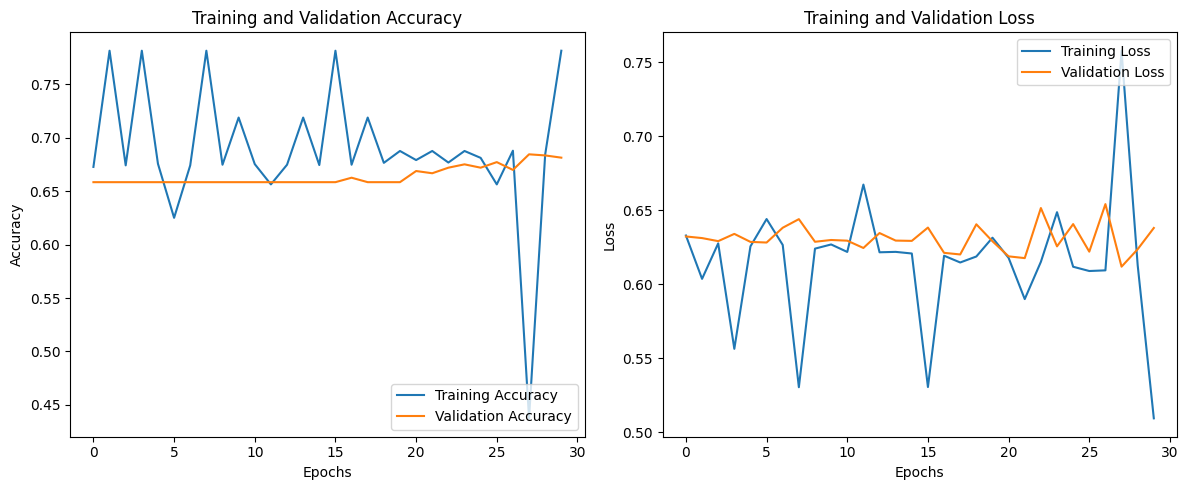

In [18]:
if history and history.history: # Check if history object exists and has data
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs_range = range(len(acc) if acc else 0)

    plt.figure(figsize=(12, 5))

    if acc and val_acc:
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
    elif acc: # Only training accuracy available
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')


    if loss and val_loss:
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
    elif loss: # Only training loss available
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.legend(loc='upper right')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

    if not acc and not loss:
        print("No accuracy or loss data to plot from training history.")
    else:
        plt.tight_layout()
        plt.show()
else:
    print("Skipping plotting as 'history' object is not available or training did not produce history.")

# **Step 9: Evaluate on the Test Set**

In [11]:
if test_generator is not None and test_steps > 0:
    print("\nEvaluating model on the test set...")
    try:
        test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
        print(f"\nTest Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f} ({(test_accuracy*100):.2f}%)")
    except Exception as e:
        print(f"Error during model evaluation on test set: {e}")
elif test_generator is None:
     print("\nTest generator not available. Skipping evaluation on the test set.")
else: # test_steps is 0
    print("\nTest generator available but has no steps (likely no test data found). Skipping evaluation.")


Evaluating model on the test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6737 - loss: 0.6400

Test Loss: 0.6486
Test Accuracy: 0.6750 (67.50%)


# **Step 10: Make Prediction on Dirty water image.**


--- Prediction Setup ---
Image dimensions for prediction: (150, 150)
Class mapping for prediction output: {0: 'no_plastic', 1: 'plastic'}

To make a prediction on a new image:
1. Upload an image file to your Colab environment (e.g., click 'Upload' in the file browser on the left).
2. Get the path to the uploaded image (e.g., '/content/testimage.jpg').
3. Call the function: predict_single_image('YOUR_IMAGE_PATH_HERE', model, class_map_for_prediction)

--- Predicting on a sample image from the test set: /content/testimage.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


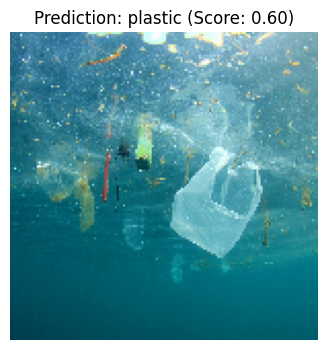

Raw prediction score: 0.6022
Predicted label: plastic


In [16]:
# Ensure IMG_HEIGHT and IMG_WIDTH are defined from Step 3
# If not, define them here (should match training dimensions)
# IMG_HEIGHT = 150
# IMG_WIDTH = 150

def predict_single_image(image_path, model_to_use, class_names_map_for_prediction):
    try:
        # Load and preprocess the image
        img = image.load_img('/content/testimage.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH)) # Use IMG_HEIGHT, IMG_WIDTH
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Create a batch
        img_array /= 255.0  # Rescale pixel values to [0, 1]

        # Make a prediction
        prediction_score = model_to_use.predict(img_array)[0][0] # Get the single probability output

        # Display the image
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis('off')

        # Interpret the prediction
        # class_names_map_for_prediction is like {0: 'no_plastic', 1: 'plastic'}
        # If prediction_score > 0.5, it's closer to class 1 (e.g., 'plastic')
        # If prediction_score <= 0.5, it's closer to class 0 (e.g., 'no_plastic')

        # Determine predicted label based on the threshold 0.5
        # and the mapping from class_indices
        predicted_label = class_names_map_for_prediction[1] if prediction_score > 0.5 else class_names_map_for_prediction[0]

        title = f"Prediction: {predicted_label} (Score: {prediction_score:.2f})"
        plt.title(title)
        plt.show()

        print(f"Raw prediction score: {prediction_score:.4f}") # e.g., 0.03 for no_plastic, 0.98 for plastic
        print(f"Predicted label: {predicted_label}")

    except FileNotFoundError:
        print(f"ERROR: Image file not found at '{'/content/testimage.jpg'}'.") # Use image_path variable
    except Exception as e:
        print(f"An error occurred during prediction: {e}")

# --- Example Usage ---
# Ensure your train_generator was successfully created in Step 4 to get class_indices
# and your model was trained in Step 7.

if 'train_generator' in globals() and train_generator is not None and \
   'model' in globals() and model is not None:

    # Create a map from index (0 or 1) to class name string for easy lookup during prediction
    # train_generator.class_indices is typically like {'no_plastic': 0, 'plastic': 1}
    # We need to reverse it to: {0: 'no_plastic', 1: 'plastic'}
    class_map_for_prediction = {v: k for k, v in train_generator.class_indices.items()}

    print("\n--- Prediction Setup ---")
    print(f"Image dimensions for prediction: ({IMG_HEIGHT}, {IMG_WIDTH})")
    print(f"Class mapping for prediction output: {class_map_for_prediction}")
    print("\nTo make a prediction on a new image:")
    print("1. Upload an image file to your Colab environment (e.g., click 'Upload' in the file browser on the left).")
    print("2. Get the path to the uploaded image (e.g., '/content/testimage.jpg').")
    print("3. Call the function: predict_single_image('YOUR_IMAGE_PATH_HERE', model, class_map_for_prediction)")

    # --- Example: Predict on the first image from your test set (if available) ---
    if 'df_test' in globals() and not df_test.empty and 'test_img_dir' in globals() and 'FILENAME_COL' in globals():
        try:
            sample_image_filename = df_test.iloc[0][FILENAME_COL]
            sample_image_path = os.path.join(test_img_dir, sample_image_filename)

            if os.path.exists('/content/testimage.jpg'):
                print(f"\n--- Predicting on a sample image from the test set: {'/content/testimage.jpg'} ---")
                predict_single_image('/content/testimage.jpg', model, class_map_for_prediction)
            else:
                print(f"\nSample image for prediction demo not found at: {'/content/testimage.jpg'}")
        except Exception as e:
            print(f"\nCould not run prediction demo on a test set image: {e}")
    else:
        print("\nTest data (df_test or test_img_dir or FILENAME_COL) not available, skipping prediction demo on a test set image.")

    # --- Example: How to call with a manually specified path after uploading ---
    # After uploading an image named 'uploaded_plastic_test.jpg' to the /content/ directory:
    # test_image_path = '/content/testimage.jpg'
    # if os.path.exists(test_image_path):
    # predict_single_image(test_image_path, model, class_map_for_prediction)
    # else:
    # print(f"Manual test image not found at {test_image_path}. Please upload it first.")

else:
    print("\nCannot set up prediction example because 'train_generator' or 'model' was not initialized correctly.")
    print("Please ensure Step 4 (data preparation) and Step 7 (model training) completed successfully.")

# **Step 11: Making prediction on Clean water image.**


--- Prediction Setup ---
Image dimensions for prediction: (150, 150)
Class mapping for prediction output: {0: 'no_plastic', 1: 'plastic'}

To make a prediction on a new image:
1. Upload an image file to your Colab environment (e.g., click 'Upload' in the file browser on the left).
2. Get the path to the uploaded image (e.g., '/content/Cleantestimage.jpg').
3. Call the function: predict_single_image('YOUR_IMAGE_PATH_HERE', model, class_map_for_prediction)

--- Predicting on a sample image from the test set: /content/Cleantestimage.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


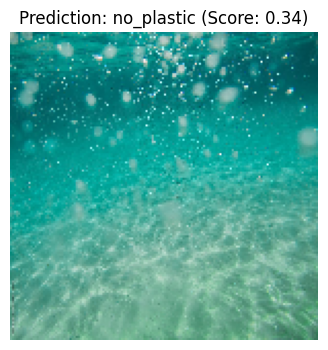

Raw prediction score: 0.3446
Predicted label: no_plastic


In [17]:
# Ensure IMG_HEIGHT and IMG_WIDTH are defined from Step 3
# If not, define them here (should match training dimensions)
# IMG_HEIGHT = 150
# IMG_WIDTH = 150

def predict_single_image(image_path, model_to_use, class_names_map_for_prediction):
    try:
        # Load and preprocess the image
        img = image.load_img('/content/Cleantestimage.jpg', target_size=(IMG_HEIGHT, IMG_WIDTH)) # Use IMG_HEIGHT, IMG_WIDTH
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Create a batch
        img_array /= 255.0  # Rescale pixel values to [0, 1]

        # Make a prediction
        prediction_score = model_to_use.predict(img_array)[0][0] # Get the single probability output

        # Display the image
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis('off')

        # Interpret the prediction
        # class_names_map_for_prediction is like {0: 'no_plastic', 1: 'plastic'}
        # If prediction_score > 0.5, it's closer to class 1 (e.g., 'plastic')
        # If prediction_score <= 0.5, it's closer to class 0 (e.g., 'no_plastic')

        # Determine predicted label based on the threshold 0.5
        # and the mapping from class_indices
        predicted_label = class_names_map_for_prediction[1] if prediction_score > 0.5 else class_names_map_for_prediction[0]

        title = f"Prediction: {predicted_label} (Score: {prediction_score:.2f})"
        plt.title(title)
        plt.show()

        print(f"Raw prediction score: {prediction_score:.4f}") # e.g., 0.03 for no_plastic, 0.98 for plastic
        print(f"Predicted label: {predicted_label}")

    except FileNotFoundError:
        print(f"ERROR: Image file not found at '{'/content/Cleantestimage.jpg'}'.") # Use image_path variable
    except Exception as e:
        print(f"An error occurred during prediction: {e}")

# --- Example Usage ---
# Ensure your train_generator was successfully created in Step 4 to get class_indices
# and your model was trained in Step 7.

if 'train_generator' in globals() and train_generator is not None and \
   'model' in globals() and model is not None:

    # Create a map from index (0 or 1) to class name string for easy lookup during prediction
    # train_generator.class_indices is typically like {'no_plastic': 0, 'plastic': 1}
    # We need to reverse it to: {0: 'no_plastic', 1: 'plastic'}
    class_map_for_prediction = {v: k for k, v in train_generator.class_indices.items()}

    print("\n--- Prediction Setup ---")
    print(f"Image dimensions for prediction: ({IMG_HEIGHT}, {IMG_WIDTH})")
    print(f"Class mapping for prediction output: {class_map_for_prediction}")
    print("\nTo make a prediction on a new image:")
    print("1. Upload an image file to your Colab environment (e.g., click 'Upload' in the file browser on the left).")
    print("2. Get the path to the uploaded image (e.g., '/content/Cleantestimage.jpg').")
    print("3. Call the function: predict_single_image('YOUR_IMAGE_PATH_HERE', model, class_map_for_prediction)")

    # --- Example: Predict on the first image from your test set (if available) ---
    if 'df_test' in globals() and not df_test.empty and 'test_img_dir' in globals() and 'FILENAME_COL' in globals():
        try:
            sample_image_filename = df_test.iloc[0][FILENAME_COL]
            sample_image_path = os.path.join(test_img_dir, sample_image_filename)

            if os.path.exists('/content/Cleantestimage.jpg'):
                print(f"\n--- Predicting on a sample image from the test set: {'/content/Cleantestimage.jpg'} ---")
                predict_single_image('/content/Cleantestimage.jpg', model, class_map_for_prediction)
            else:
                print(f"\nSample image for prediction demo not found at: {'/content/Cleantestimage.jpg'}")
        except Exception as e:
            print(f"\nCould not run prediction demo on a test set image: {e}")
    else:
        print("\nTest data (df_test or test_img_dir or FILENAME_COL) not available, skipping prediction demo on a test set image.")

    # --- Example: How to call with a manually specified path after uploading ---
    # After uploading an image named 'uploaded_plastic_test.jpg' to the /content/ directory:
    # test_image_path = '/content/Cleantestimage.jpg'
    # if os.path.exists(test_image_path):
    # predict_single_image(test_image_path, model, class_map_for_prediction)
    # else:
    # print(f"Manual test image not found at {test_image_path}. Please upload it first.")

else:
    print("\nCannot set up prediction example because 'train_generator' or 'model' was not initialized correctly.")
    print("Please ensure Step 4 (data preparation) and Step 7 (model training) completed successfully.")